In [91]:
import os
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

# Get list of all CSV files in the directory
list_of_commits = list(Path("../../logs/performance/analysis").glob("*/"))
list_of_commits.sort(key=os.path.getmtime, reverse=True)
list_of_commits = list_of_commits[:1]
list_of_files = list(Path(list_of_commits[0] / "all").glob("*.csv"))

# Find the latest file
latest_file = max(list_of_files, key=os.path.getctime)

# Load the latest CSV file into a DataFrame
df_latest = pd.read_csv(latest_file)
# format: "timestamp", "category", "test_name", "query", "scenario",
#          "execution_time", "results_consistent", "fainder_mode",
#          "num_results", "ids", "num_terms", "id_str", "write_groups_used",
#          "write_groups_actually_used", "fainder_parallel", "fainder_max_workers",
#          "fainder_contiguous_chunks", "optimizer_cost_sorting",
#          "optimizer_keyword_merging", "optimizer_split_up_junctions"
print(df_latest)

# First check the unique category values to see what we're working with
print("Unique categories:", df_latest["category"].unique())

# Strip whitespace and normalize the category column
df_latest["category"] = df_latest["category"].str.strip()



os.makedirs("figures/analysis", exist_ok=True)

               timestamp                      category  \
0    2025-05-31 15:45:55          base_keyword_queries   
1    2025-05-31 15:45:55          base_keyword_queries   
2    2025-05-31 15:45:55          base_keyword_queries   
3    2025-05-31 15:45:55          base_keyword_queries   
4    2025-05-31 15:45:55          base_keyword_queries   
..                   ...                           ...   
947  2025-05-31 16:10:23  double_expected_form_queries   
948  2025-05-31 16:10:43  double_expected_form_queries   
949  2025-05-31 16:10:43  double_expected_form_queries   
950  2025-05-31 16:10:43  double_expected_form_queries   
951  2025-05-31 16:10:43  double_expected_form_queries   

                   test_name  \
0           simple_keyword_1   
1           simple_keyword_1   
2           simple_keyword_1   
3           simple_keyword_1   
4           simple_keyword_1   
..                       ...   
947  double_expected_form_10   
948  double_expected_form_10   
949  double_exp

In [92]:
# Filter the DataFrame by category with stripped values
base_keyword_queries = df_latest[df_latest["category"] == "base_keyword_queries"].reset_index(drop=True)
base_keyword_queries_with_multiple_elements = df_latest[
    df_latest["category"] == "base_keyword_queries_with_multiple_elements"
].reset_index(drop=True)
base_percentile_queries = df_latest[df_latest["category"] == "base_percentile_queries"].reset_index(drop=True)
percentile_combinations = df_latest[df_latest["category"] == "percentile_combinations"].reset_index(drop=True)
mixed_combinations_with_fixed_structure = df_latest[
    df_latest["category"] == "mixed_combinations_with_fixed_structure"
].reset_index(drop=True)
mixed_combinations_with_fixed_structure_extented = df_latest[
    df_latest["category"] == "mixed_combinations_with_fixed_structure_extented"
].reset_index(drop=True)
early_exit = df_latest[df_latest["category"] == "early_exit"].reset_index(drop=True)
# Filter for multiple percentile combinations
multiple_percentile_combinations = df_latest[
    df_latest["category"] == "multiple_percentile_combinations"
].reset_index(drop=True)
multiple_percentile_combinations_with_kw = df_latest[
    df_latest["category"] == "multiple_percentile_combinations_with_kw"
].reset_index(drop=True)
expected_form_not_queries = df_latest[
    df_latest["category"] == "expected_form_not_queries"
].reset_index(drop=True)
double_expected_form_queries = df_latest[
    df_latest["category"] == "double_expected_form_queries"
].reset_index(drop=True)
middle_exit = df_latest[df_latest["category"] == "middle_exit"].reset_index(drop=True)


# Print to verify the filtering worked
print("\nCounts after fixing whitespace:")
print("Base keyword queries:", len(base_keyword_queries))
print("Base keyword queries with multiple elements:", len(base_keyword_queries_with_multiple_elements))
print("Base percentile queries:", len(base_percentile_queries))
print("Percentile combinations:", len(percentile_combinations))
print("Mixed combinations with fixed structure:", len(mixed_combinations_with_fixed_structure))
print("Mixed combinations with fixed structure extended:", len(mixed_combinations_with_fixed_structure_extented))
print("Early exit:", len(early_exit))
print("Multiple percentile combinations:", len(multiple_percentile_combinations))
print("Multiple percentile combinations with keyword:", len(multiple_percentile_combinations_with_kw))
print("Expected form not queries:", len(expected_form_not_queries))
print("Double expected form queries:", len(double_expected_form_queries))
print("Middle exit:", len(middle_exit))
# Prepare data for plotting
# Get unique scenarios and colors for plotting
scenarios = base_keyword_queries["scenario"].unique()
colors = ["r", "g", "b", "y", "c", "m", "k"]


Counts after fixing whitespace:
Base keyword queries: 80
Base keyword queries with multiple elements: 80
Base percentile queries: 40
Percentile combinations: 96
Mixed combinations with fixed structure: 80
Mixed combinations with fixed structure extended: 80
Early exit: 80
Multiple percentile combinations: 64
Multiple percentile combinations with keyword: 72
Expected form not queries: 120
Double expected form queries: 80
Middle exit: 0


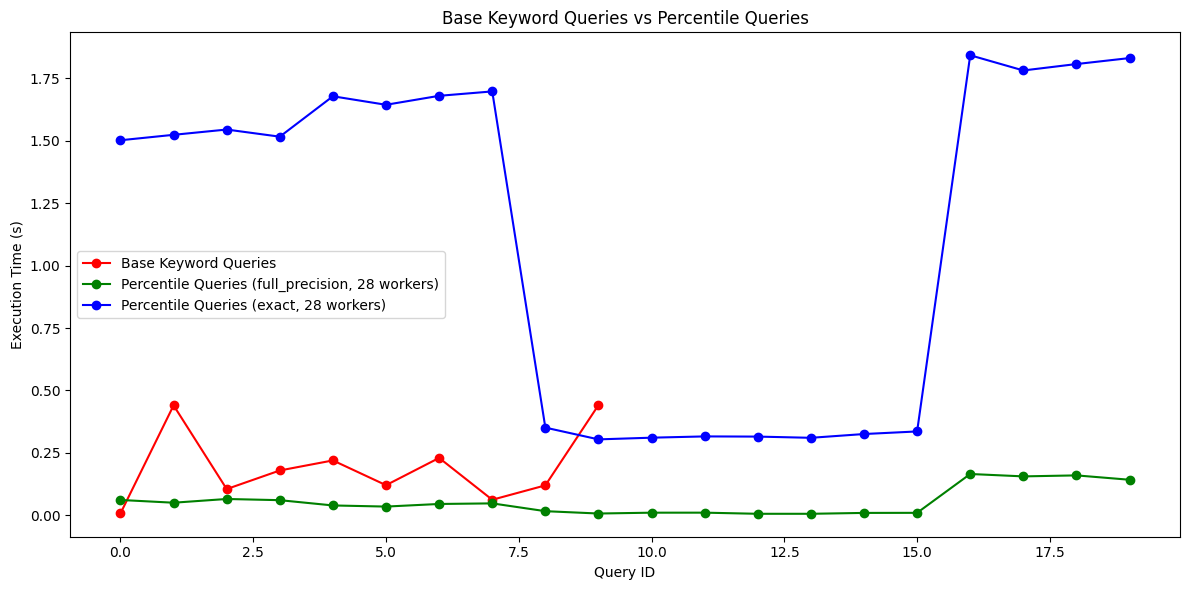

In [93]:
# a plot with three lines (one base_keyword_queries and two percentile queries (different fainder modes) per num_workers) x-axis is queryid
plt.figure(figsize=(12, 6))
plt.title("Base Keyword Queries vs Percentile Queries")
plt.xlabel("Query ID")
plt.ylabel("Execution Time (s)")

# Plot base keyword queries
base_keyword_queries = base_keyword_queries.groupby("query")["execution_time"].mean().reset_index()
plt.plot(
    base_keyword_queries.index,
    base_keyword_queries["execution_time"],
    label="Base Keyword Queries",
    color=colors[0],
    marker="o",
)
# Plot base percentile queries
num_workers = base_percentile_queries["fainder_max_workers"].unique()
for num_worker in num_workers:
    percentile_queries = base_percentile_queries[base_percentile_queries["fainder_max_workers"] == num_worker].reset_index(drop=True)
    fainder_modes = percentile_queries["fainder_mode"].unique()
    for i, fainder_mode in enumerate(fainder_modes):
        mode_queries = percentile_queries[percentile_queries["fainder_mode"] == fainder_mode].reset_index(drop=True)
        plt.plot(
            mode_queries.index,
            mode_queries["execution_time"],
            label=f"Percentile Queries ({fainder_mode}, {num_worker} workers)",
            color=colors[i + 1],
            marker="o",
        )
plt.xticks()
plt.legend()
plt.tight_layout()
plt.savefig("figures/analysis/base_predicates.png")

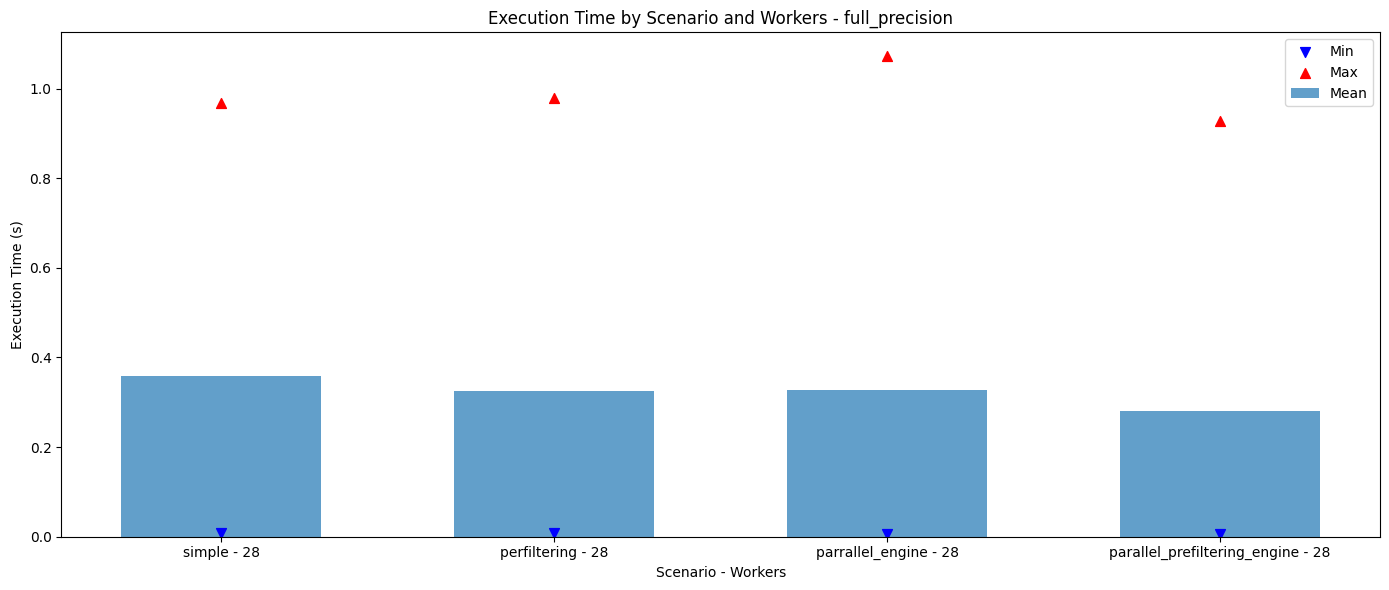

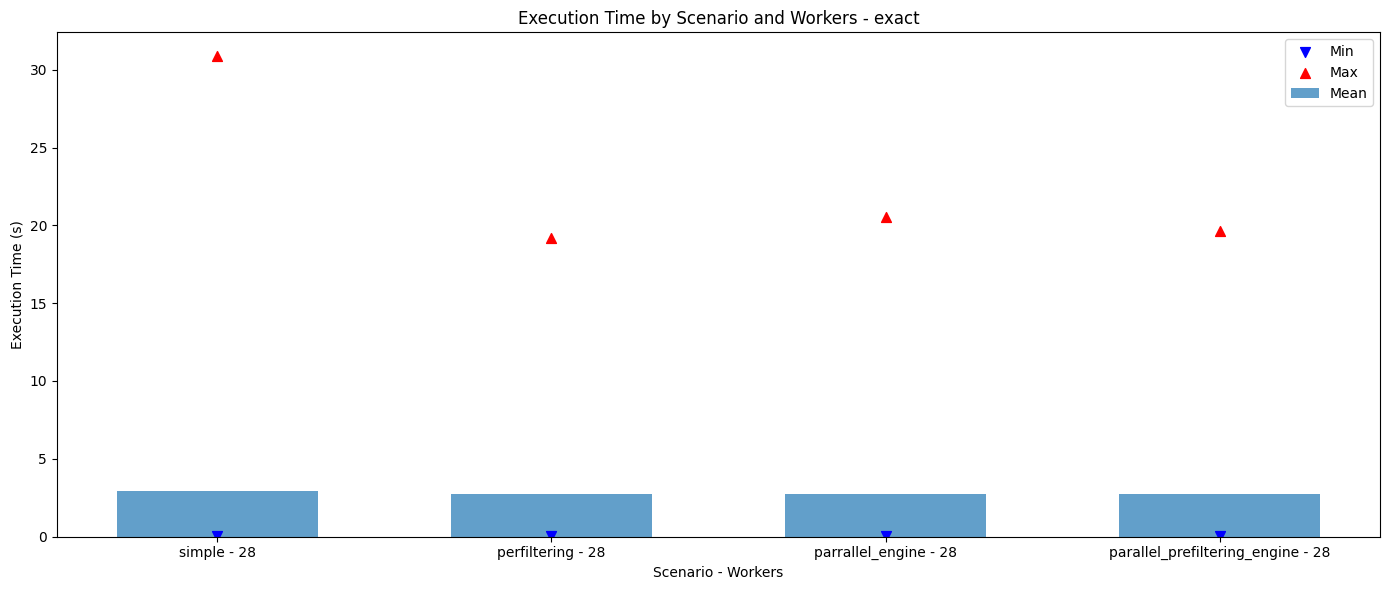

In [94]:
# Compare execution time (y-axis min, max, mean) against scenario and num_workers (x-axis) for one plot per fainder mode
import numpy as np

for fainder_mode in df_latest["fainder_mode"].unique():
    df_fainder_mode = df_latest[df_latest["fainder_mode"] == fainder_mode]
    
    plt.figure(figsize=(14, 6))
    plt.title(f"Execution Time by Scenario and Workers - {fainder_mode}")
    plt.xlabel("Scenario - Workers")
    plt.ylabel("Execution Time (s)")
    
    # Group by both scenario and fainder_max_workers
    grouped_data = df_fainder_mode.groupby(['scenario', 'fainder_max_workers'])
    
    # Set up positions for bar groups
    groups = list(grouped_data.groups.keys())
    x_positions = np.arange(len(groups))
    
    # Prepare labels
    labels = [f"{scenario} - {workers}" for scenario, workers in groups]
    labels.reverse()
    # Collect data for plotting
    min_times = []
    max_times = []
    mean_times = []
    
    for (scenario, workers), group in grouped_data:
        execution_times = group["execution_time"]
        
        # Calculate statistics
        min_times.append(execution_times.min())
        max_times.append(execution_times.max())
        mean_times.append(execution_times.mean())
    
    # Create bars for mean values
    plt.bar(x_positions, mean_times, width=0.6, alpha=0.7, label='Mean')
    
    # Add markers for min and max
    plt.scatter(x_positions, min_times, marker='v', color='blue', s=50, label='Min')
    plt.scatter(x_positions, max_times, marker='^', color='red', s=50, label='Max')
    
    # Set the x-tick labels to scenario-workers names
    plt.xticks(x_positions, labels)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"figures/analysis/all_categories_{fainder_mode}_by_workers.png")


/tmp/ipykernel_90953/3955538988.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14, 6))


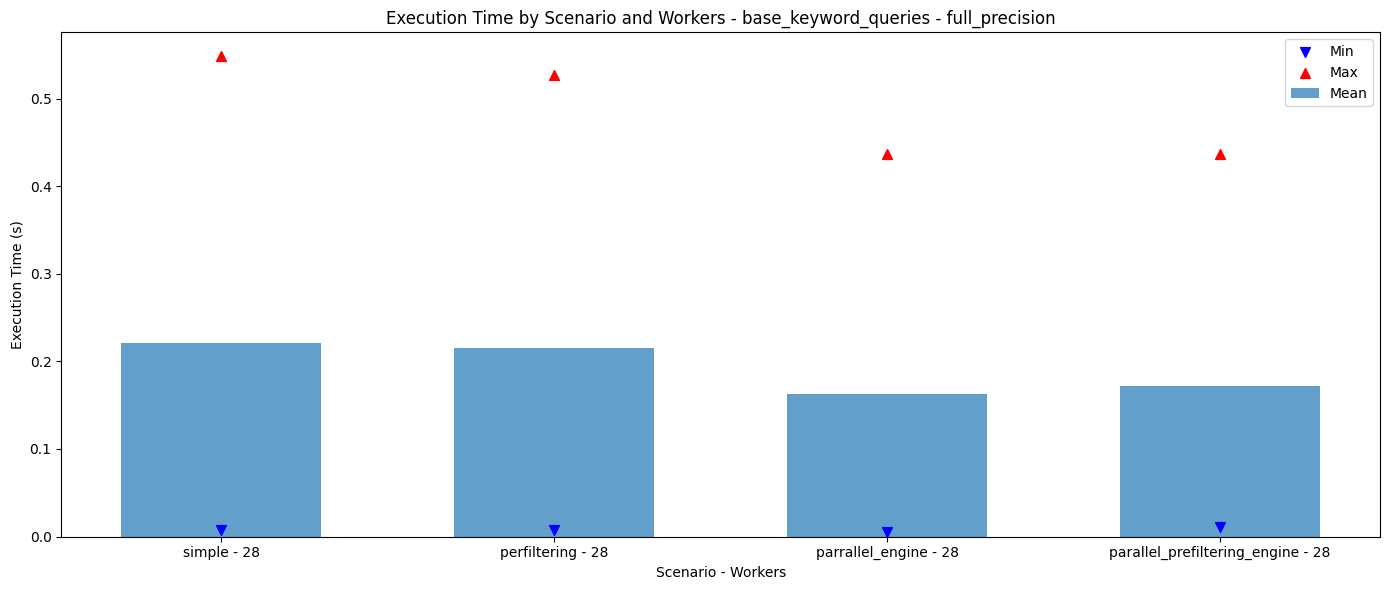

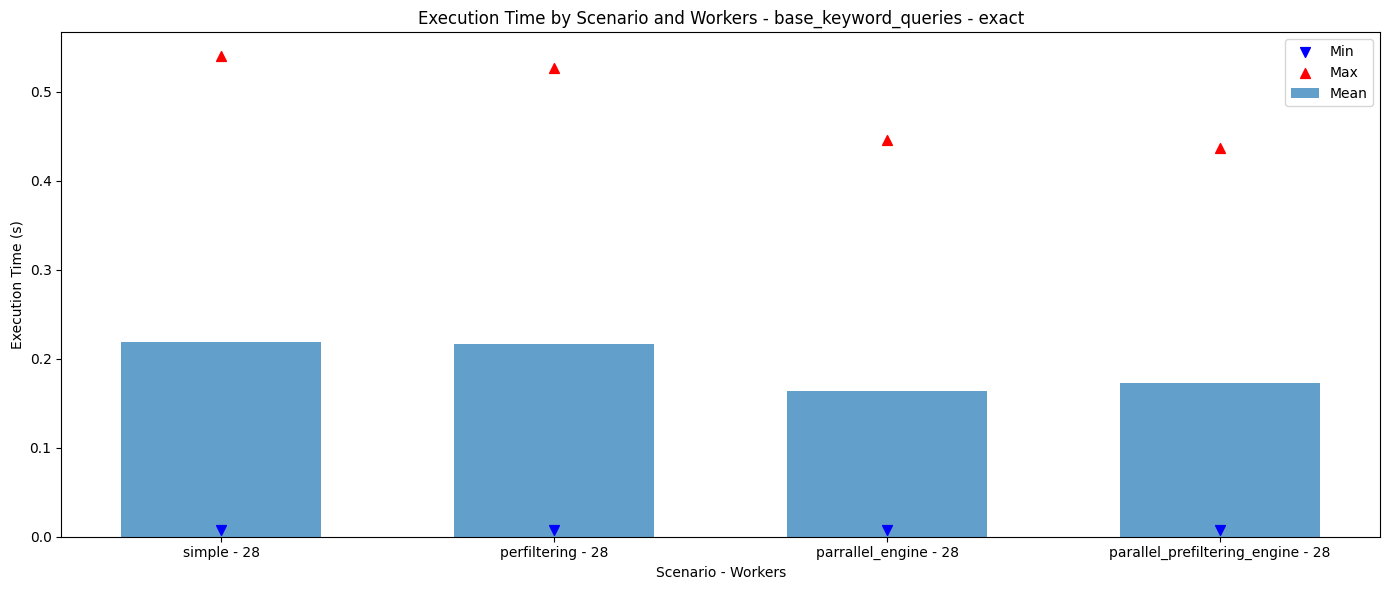

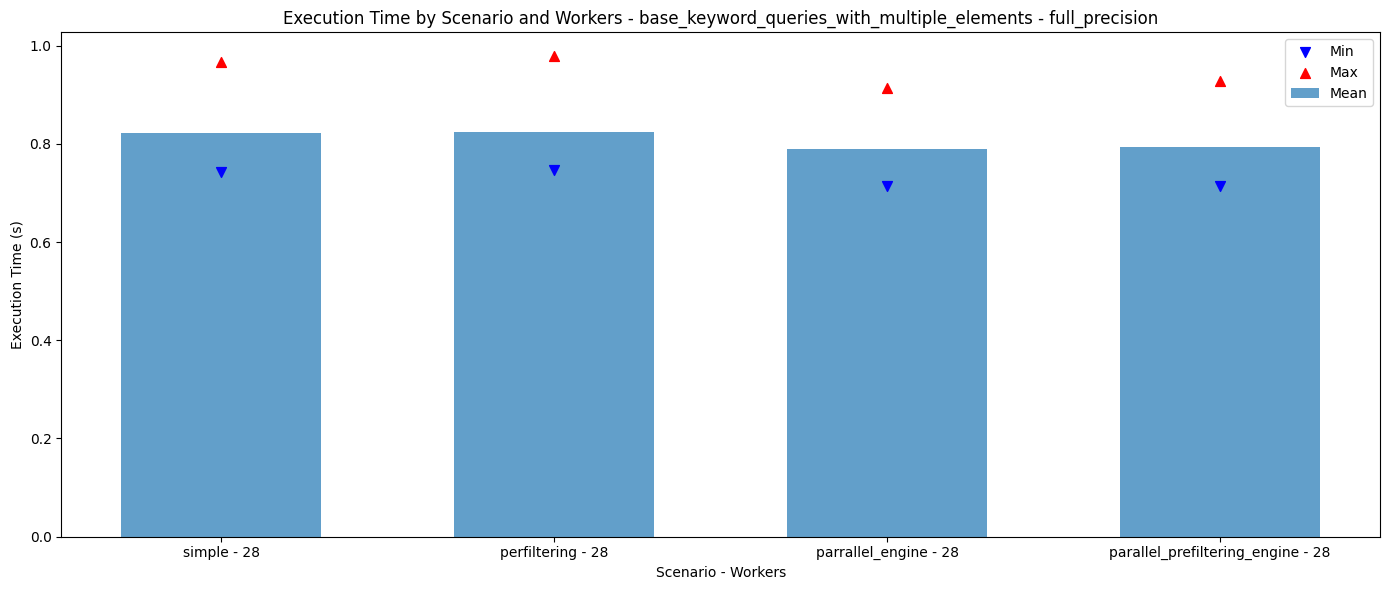

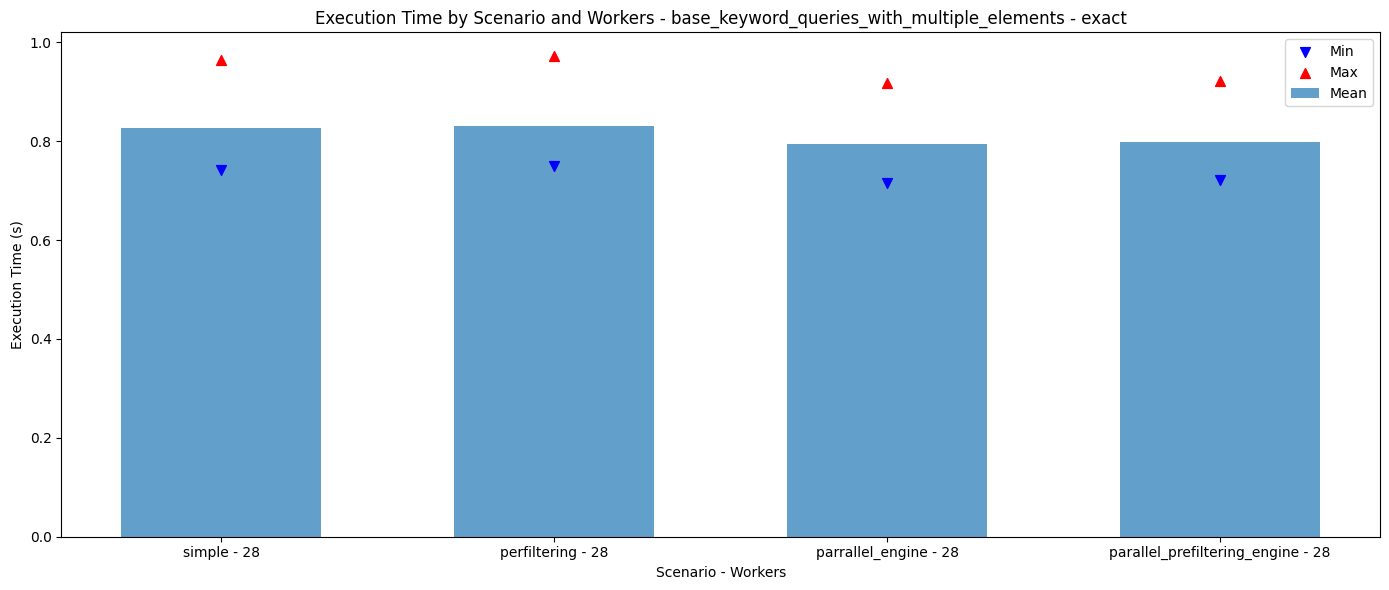

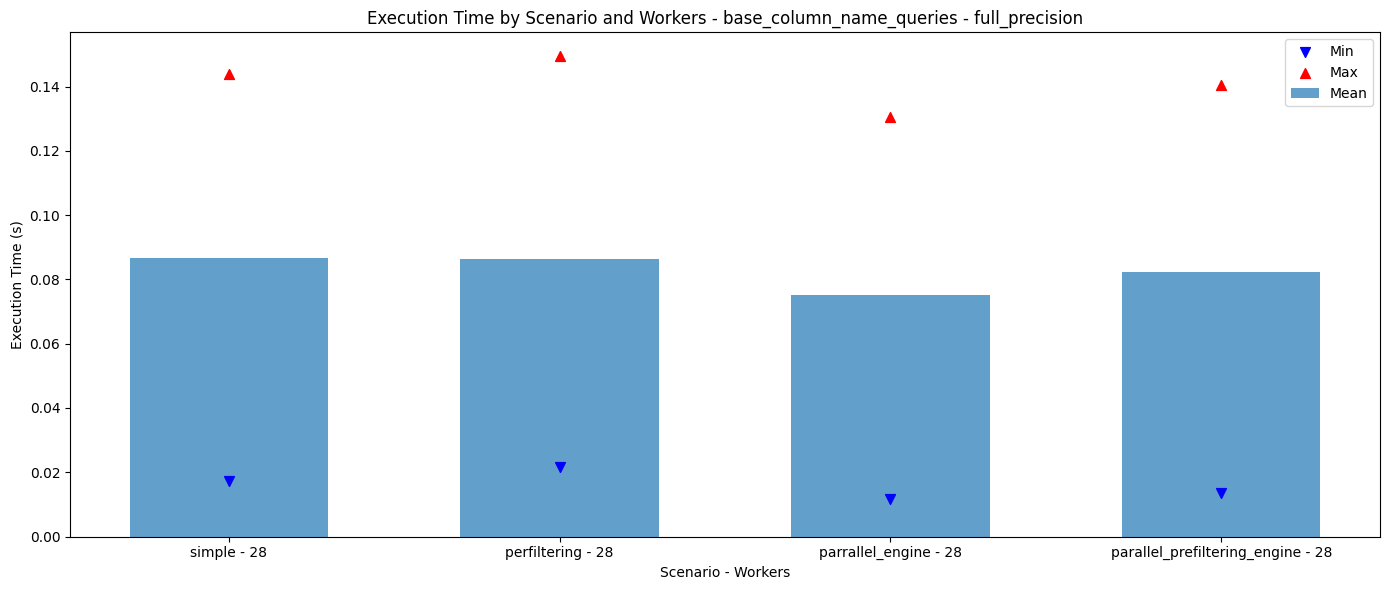

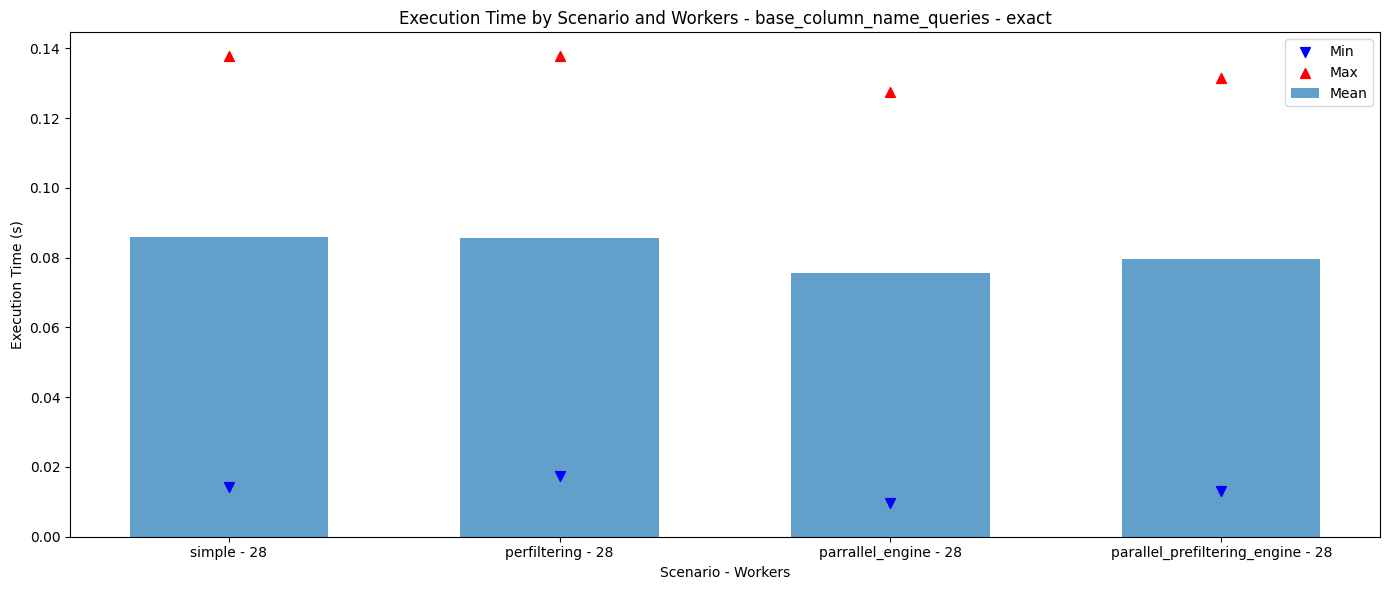

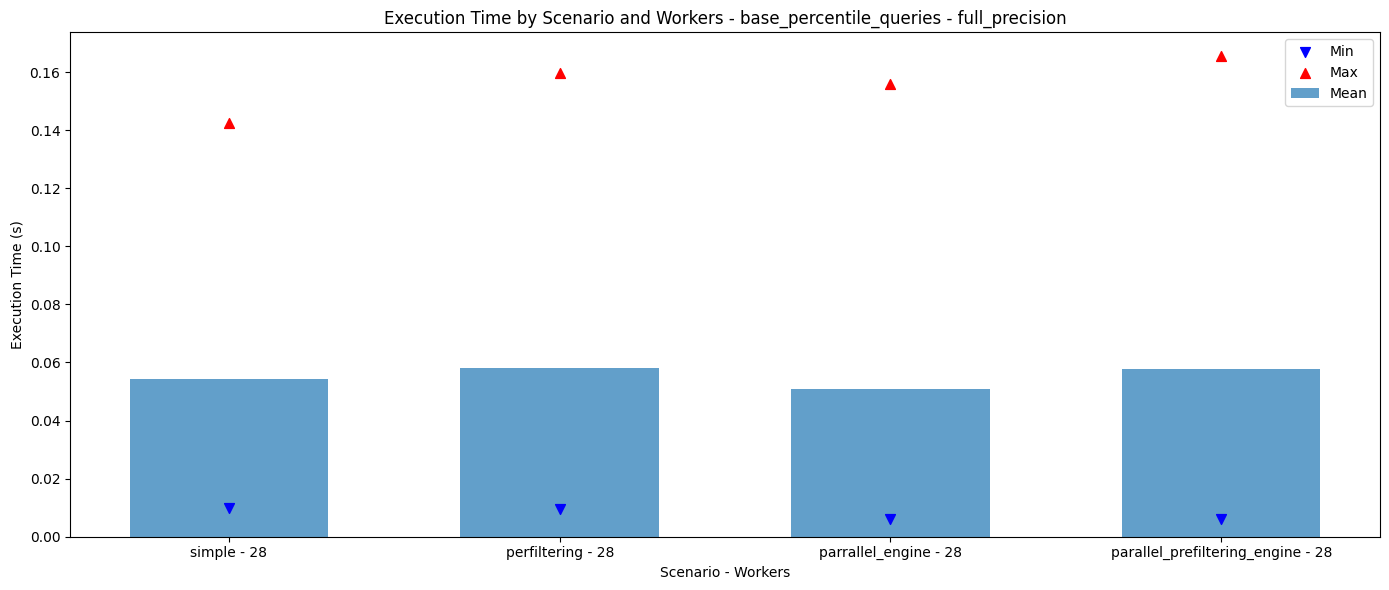

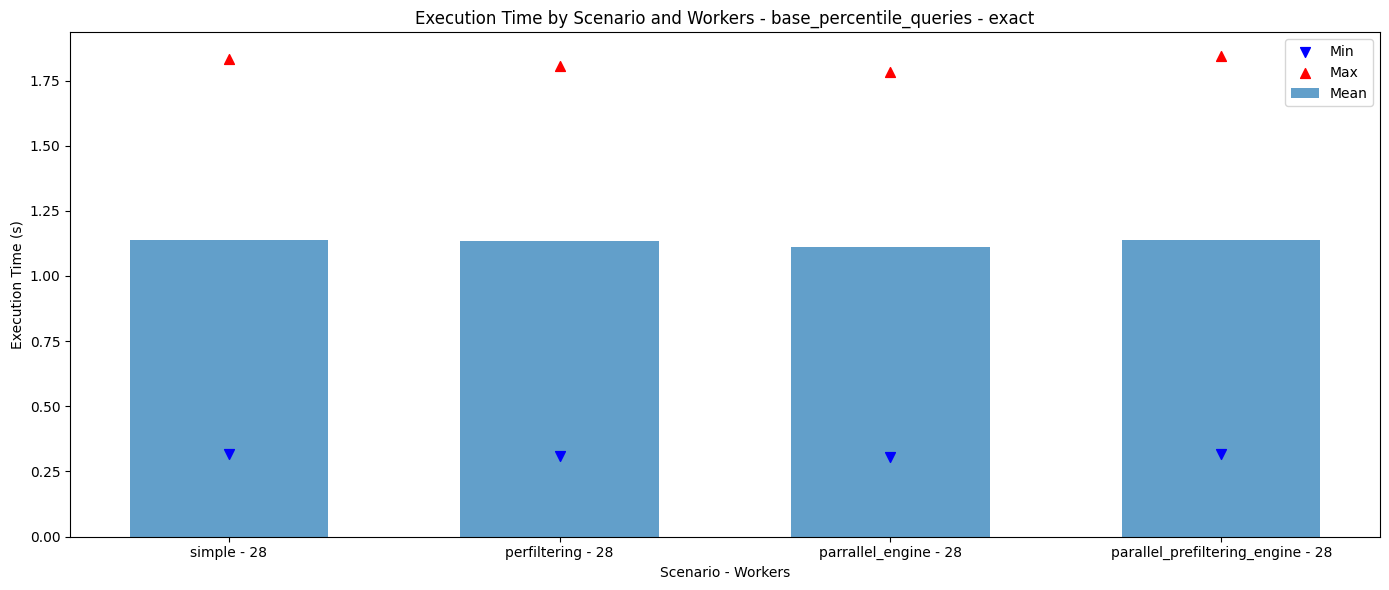

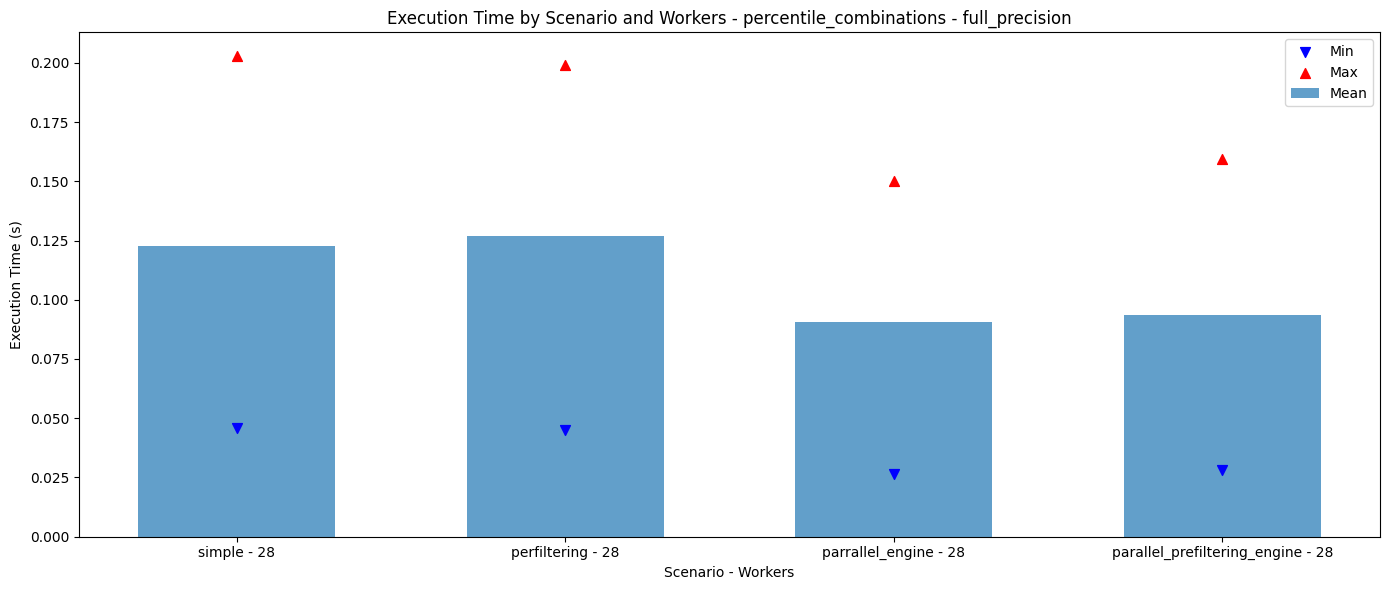

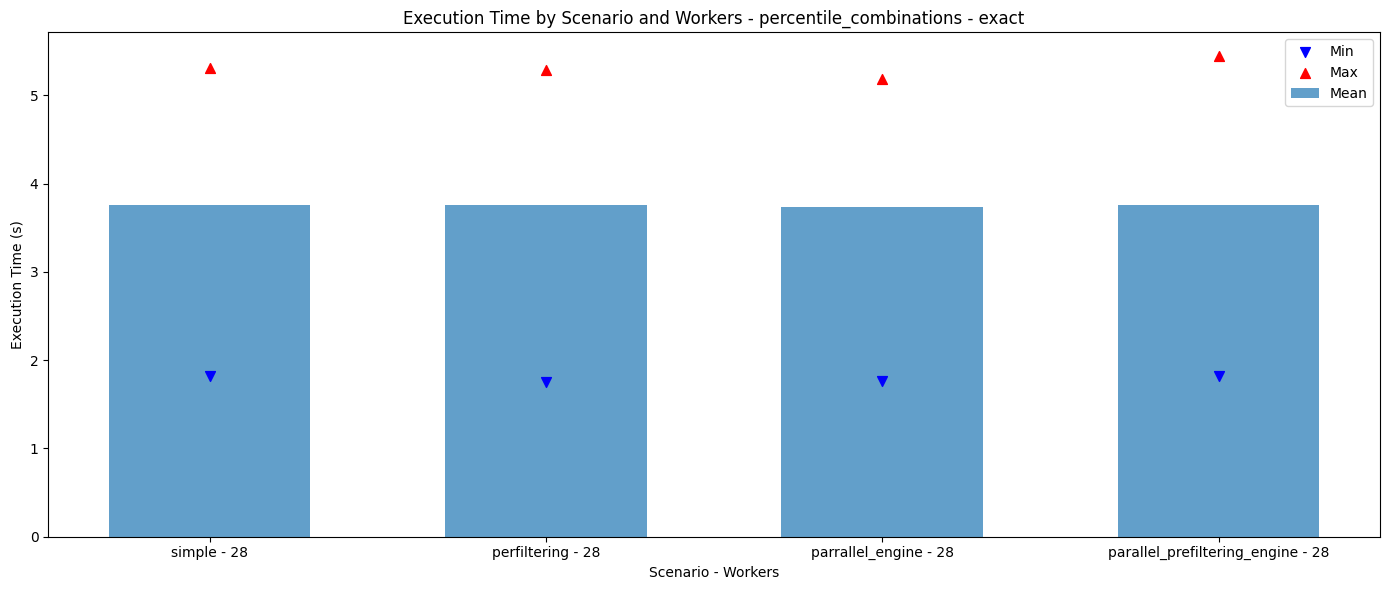

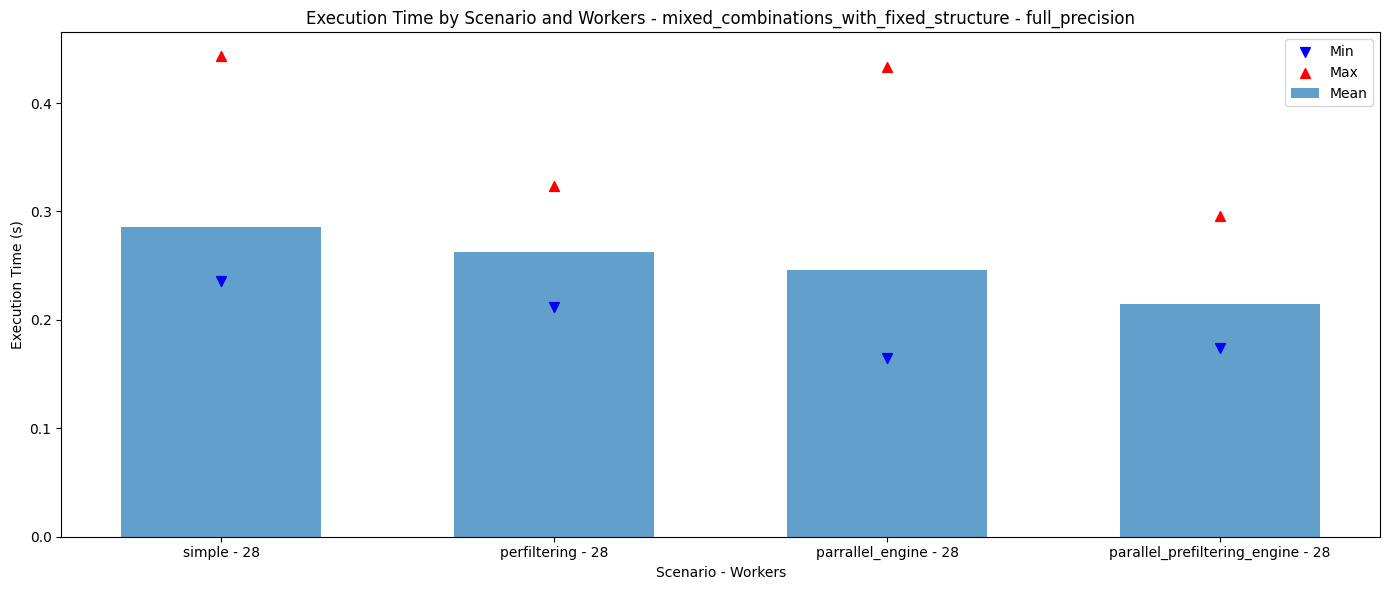

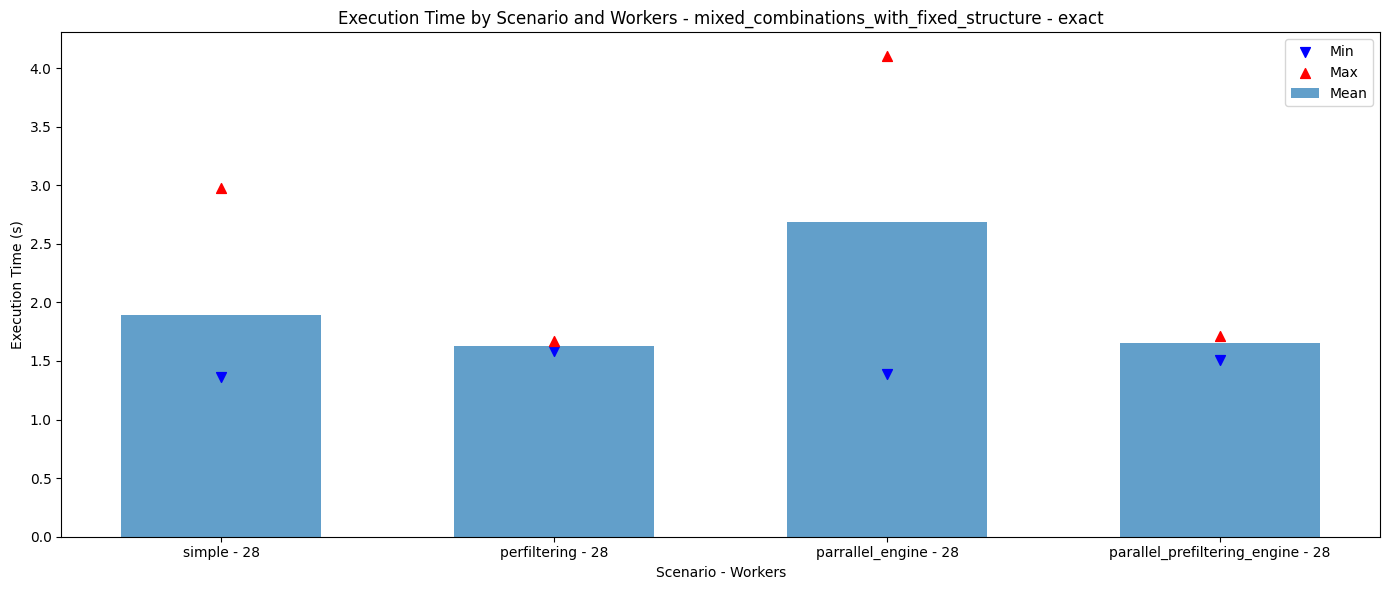

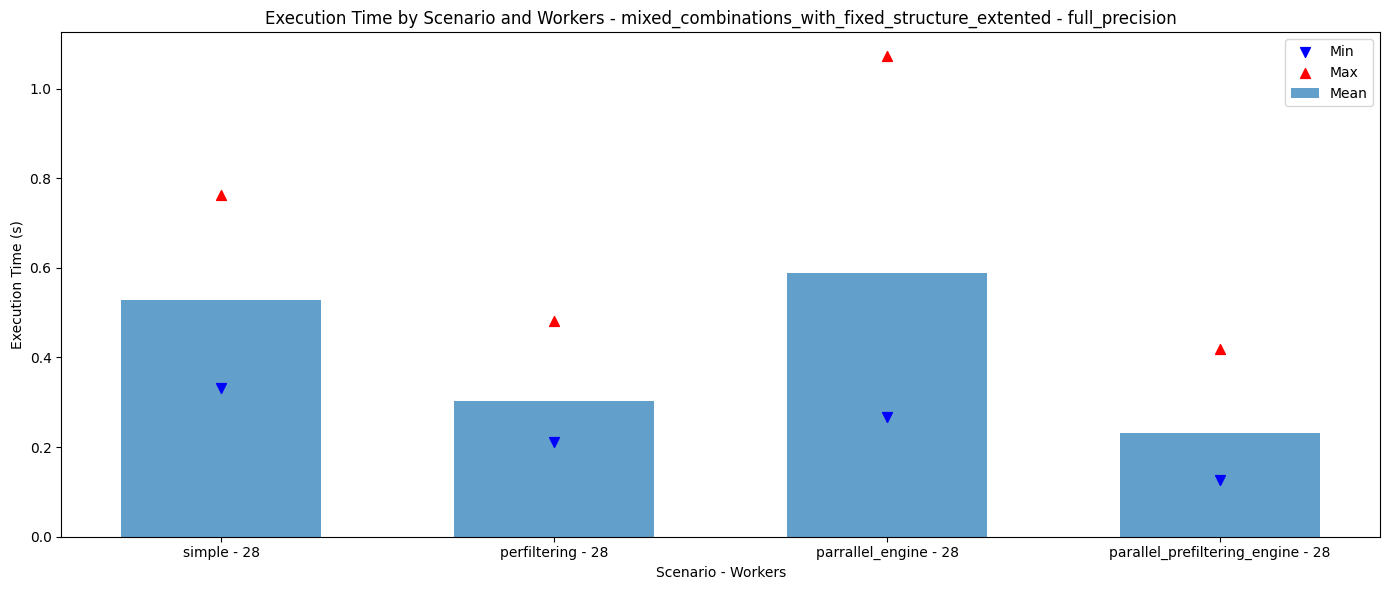

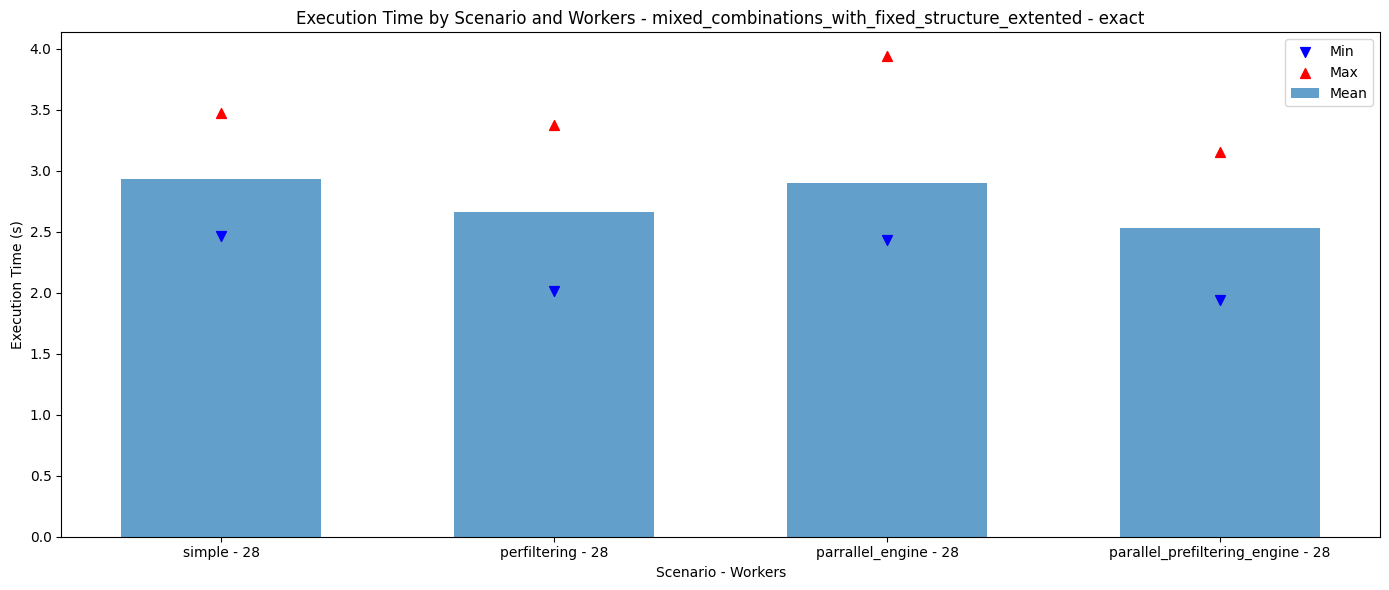

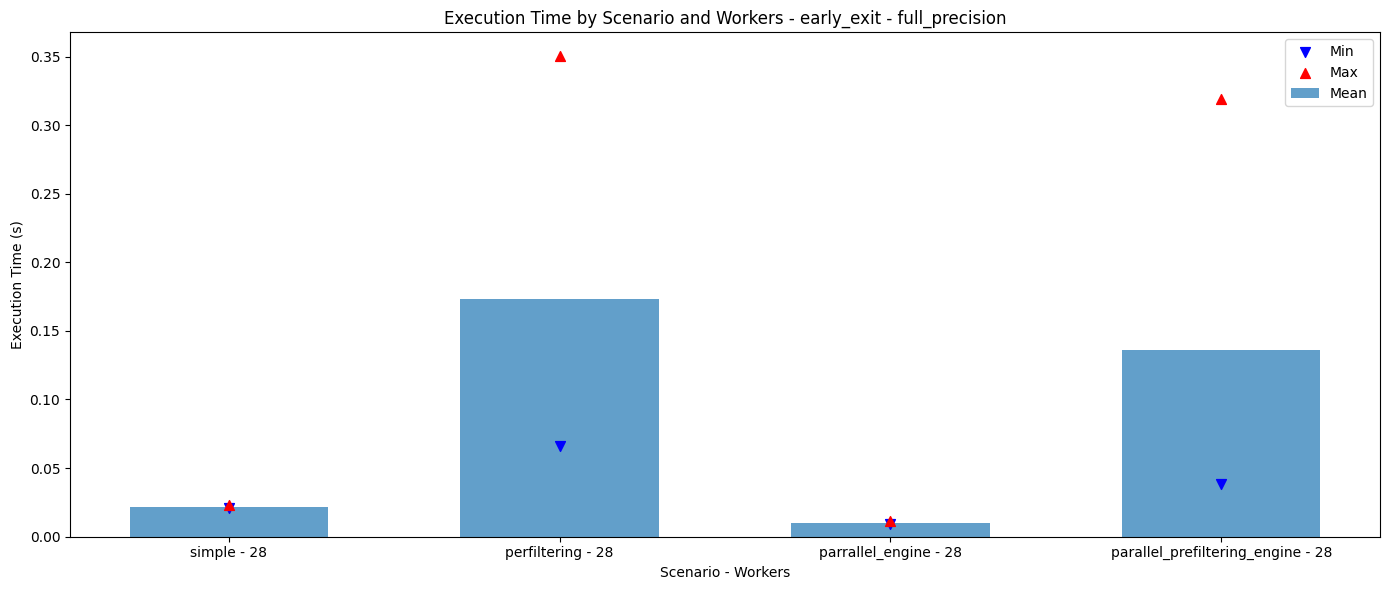

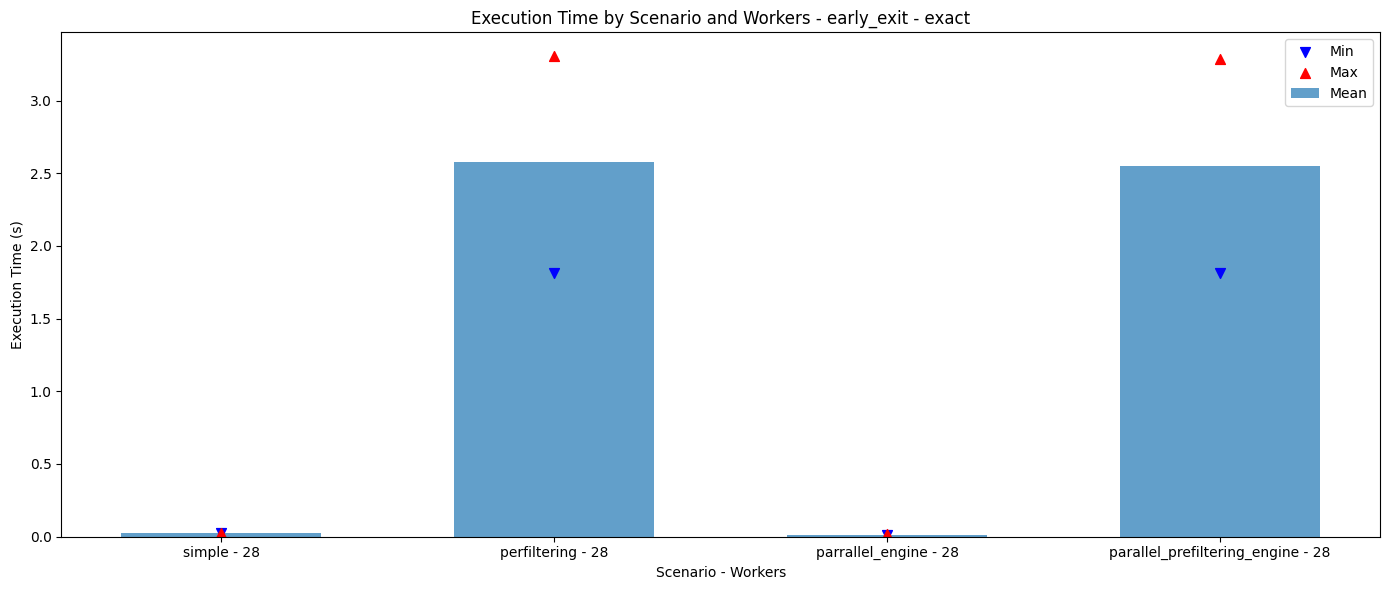

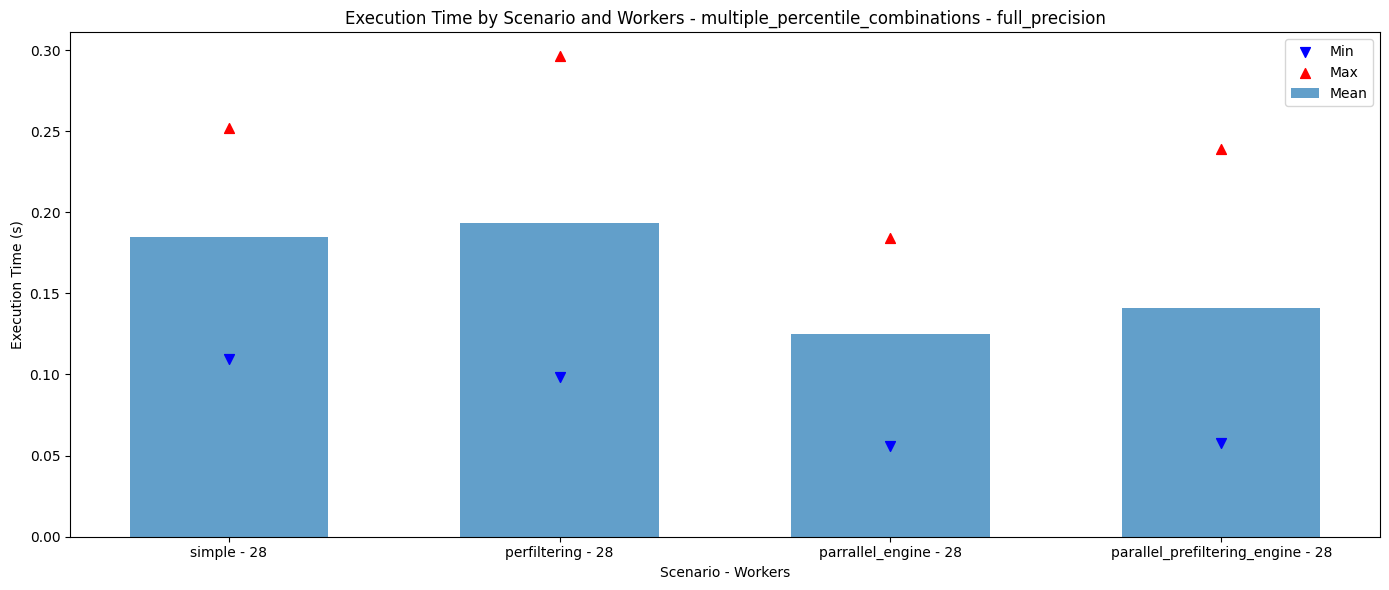

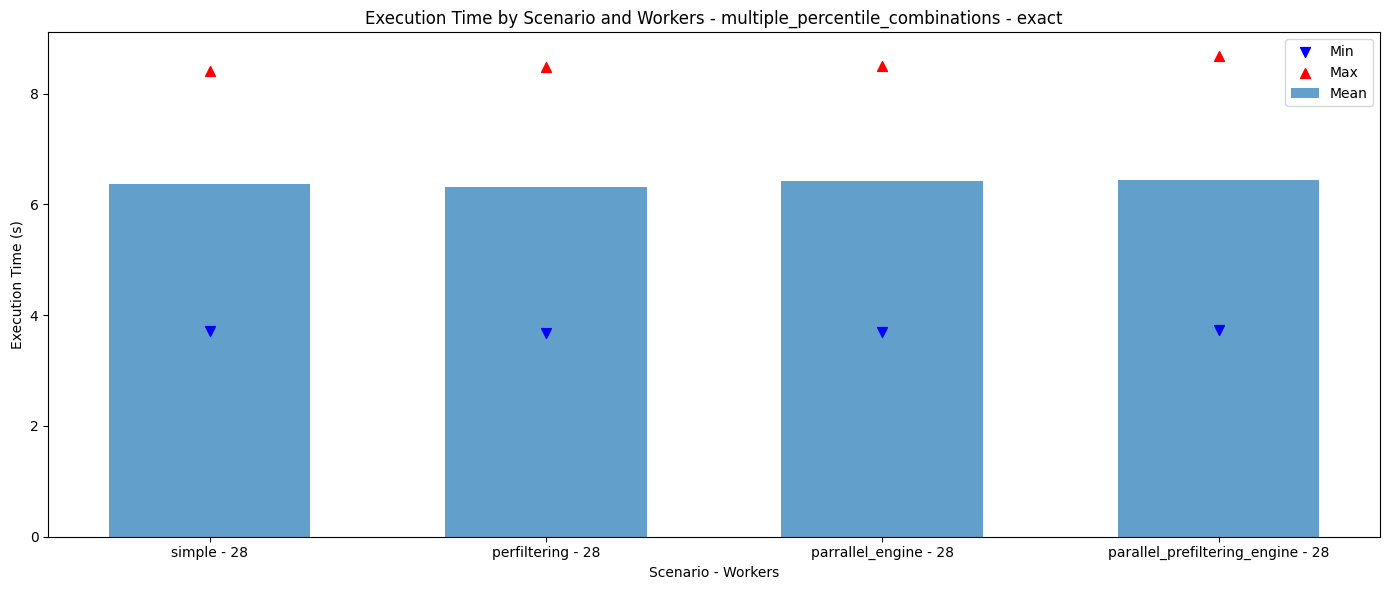

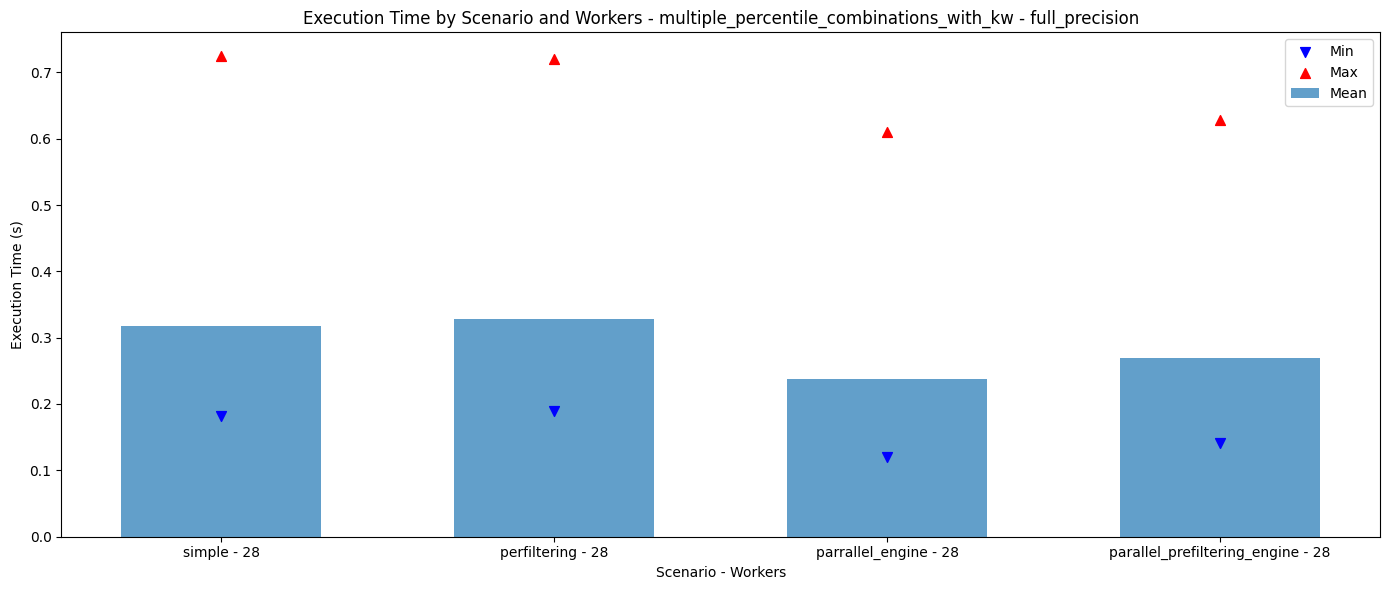

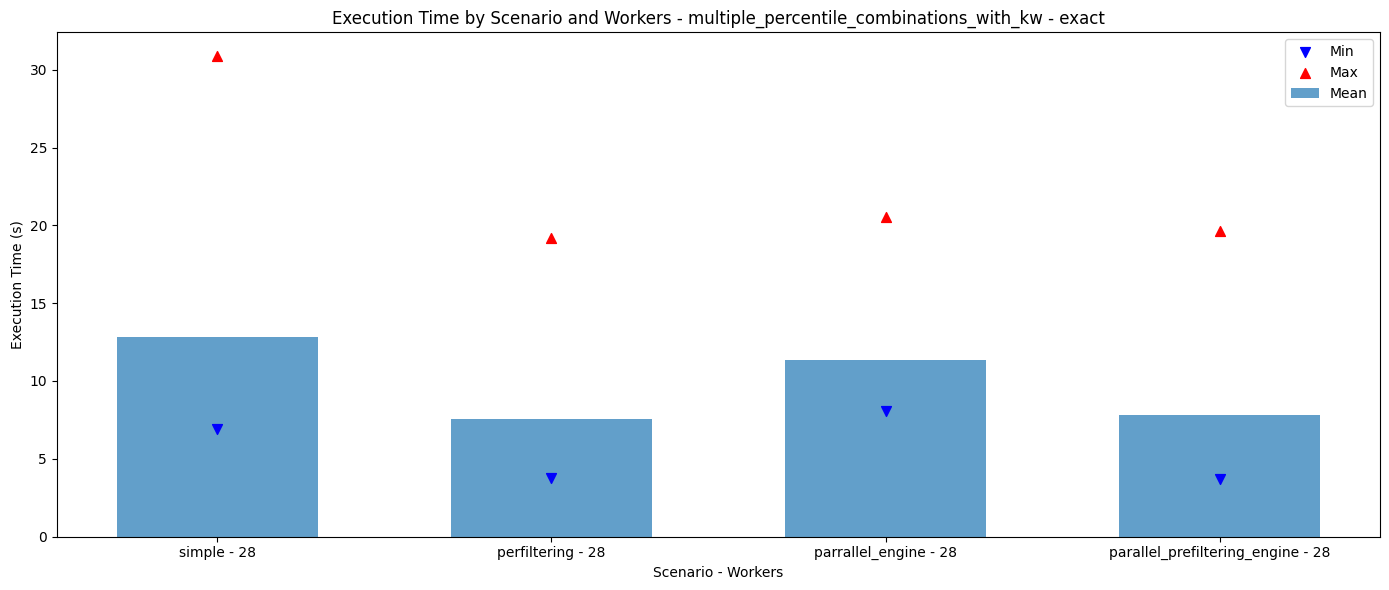

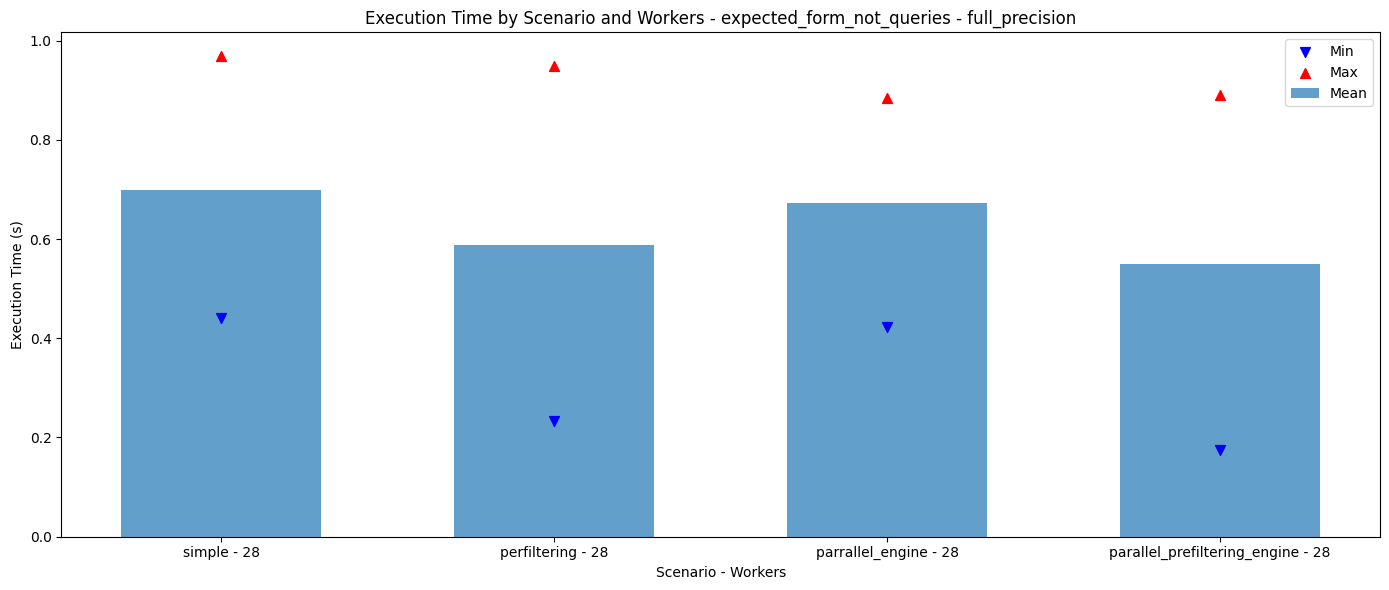

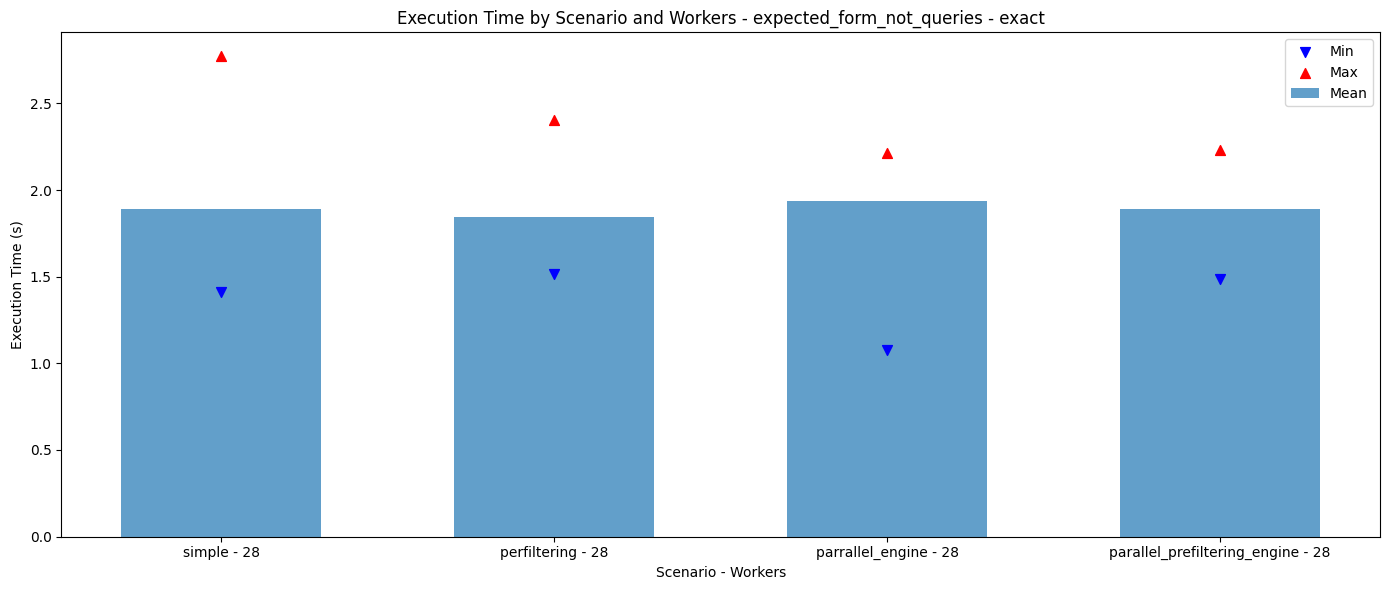

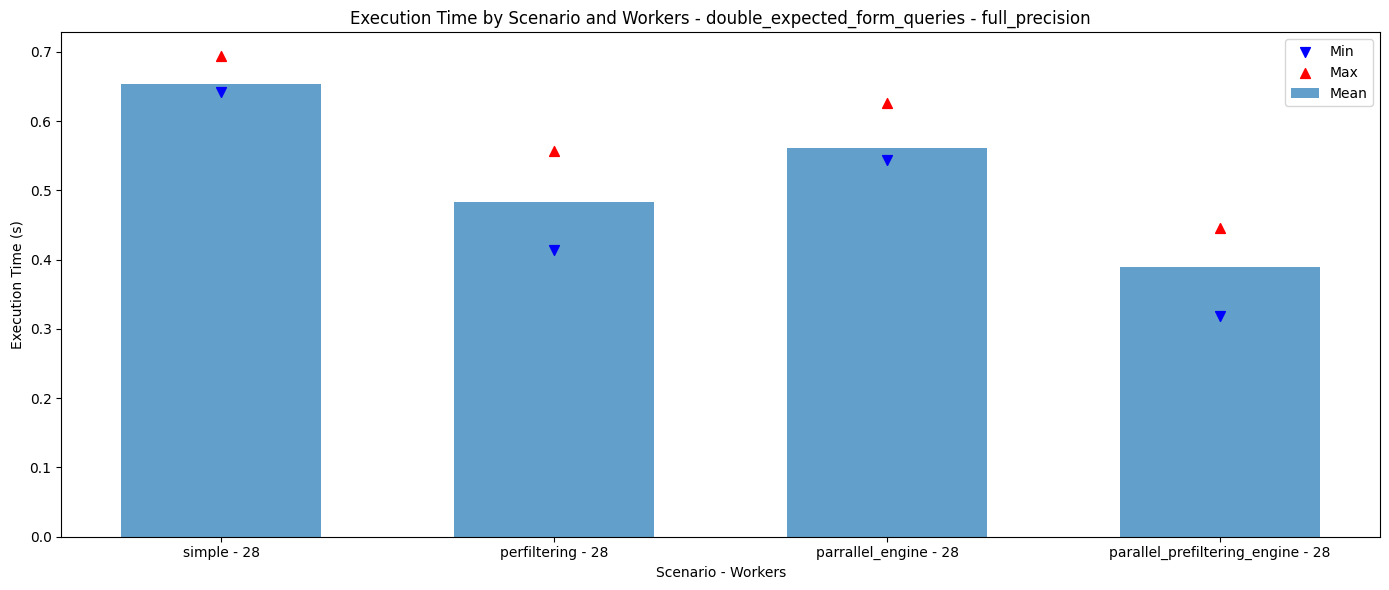

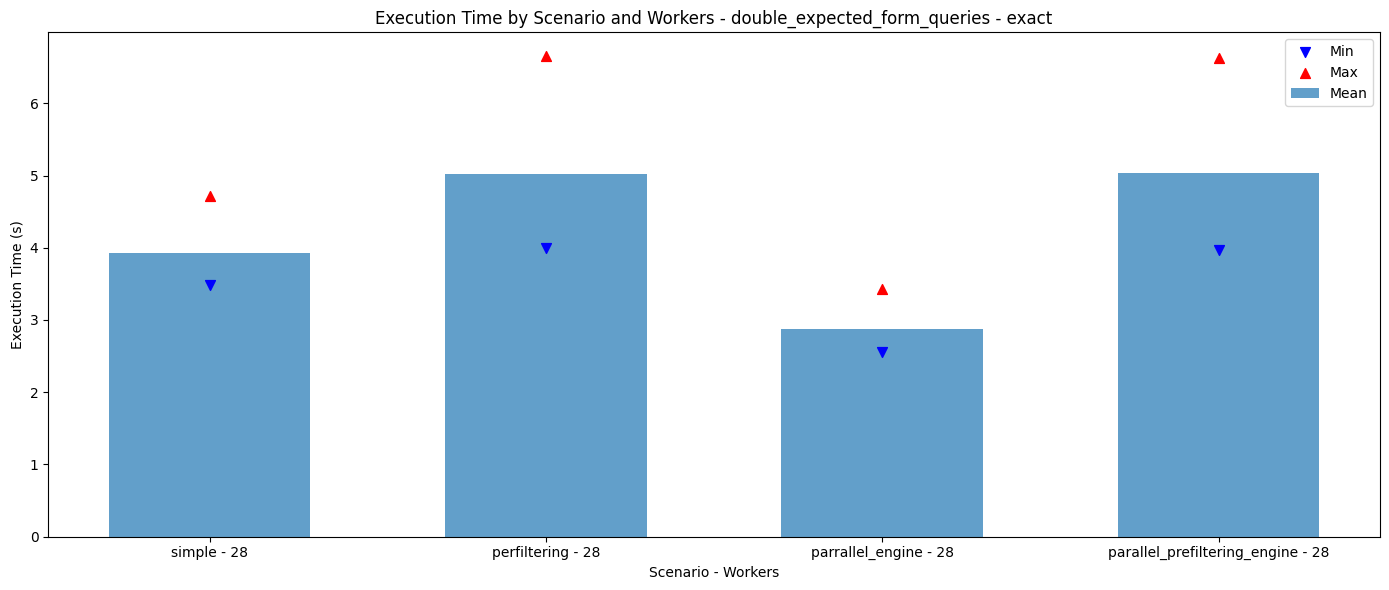

In [95]:
# Compare execution time (y-axis min, max, mean) against scenario and num_workers (x-axis) for one plot per fainder mode per category one plot
categories = df_latest["category"].unique()
for category in categories:
    df_category = df_latest[df_latest["category"] == category]
    
    for fainder_mode in df_category["fainder_mode"].unique():
        df_fainder_mode = df_category[df_category["fainder_mode"] == fainder_mode]
        
        plt.figure(figsize=(14, 6))
        plt.title(f"Execution Time by Scenario and Workers - {category} - {fainder_mode}")
        plt.xlabel("Scenario - Workers")
        plt.ylabel("Execution Time (s)")
        
        # Group by both scenario and fainder_max_workers
        grouped_data = df_fainder_mode.groupby(['scenario', 'fainder_max_workers'])
        
        # Set up positions for bar groups
        groups = list(grouped_data.groups.keys())
        x_positions = np.arange(len(groups))
        
        # Prepare labels
        labels = [f"{scenario} - {workers}" for scenario, workers in groups]
        labels.reverse()

        # Collect data for plotting
        min_times = []
        max_times = []
        mean_times = []
        
        for (scenario, workers), group in grouped_data:
            execution_times = group["execution_time"]
            
            # Calculate statistics
            min_times.append(execution_times.min())
            max_times.append(execution_times.max())
            mean_times.append(execution_times.mean())
        
        # Create bars for mean values
        plt.bar(x_positions, mean_times, width=0.6, alpha=0.7, label='Mean')
        
        # Add markers for min and max
        plt.scatter(x_positions, min_times, marker='v', color='blue', s=50, label='Min')
        plt.scatter(x_positions, max_times, marker='^', color='red', s=50, label='Max')
        
        # Set the x-tick labels to scenario-workers names
        plt.xticks(x_positions, labels)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"figures/analysis/{category}_{fainder_mode}_by_workers.png")
        